In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/queryresults/QueryResults.csv


Stack Overflow is a question-and-answer website for computer programmers.
It was created in 2008. It features questions and answers on certain computer programming topics.
As of March 2024 Stack Overflow has over 23 million registered users and has received over 24 million questions and 35 million answers.


For a dataset of 10,000 question-answer pairs, we propose to:

Perform document prepro
essing
Compare different LLM approaches (such as Gemini) to pred
ct tags
Implement, in the form of an API, a tag suggestion system for the site, ensuring that the questions are well-referenced and can be easily retrieved.

In [2]:
!pip install swifter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16507 sha256=212e93cbe63c01c755ed820df4eb98537dc9e94800d1c2762864e6eb90372f70
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built swifter


In [3]:
import pandas as pd
from transformers import pipeline
import swifter

In [4]:
df = pd.read_csv("/kaggle/input/queryresults/QueryResults.csv")
df.shape[0]

46500

In [5]:
df.shape

(46500, 10)

In [6]:
#df.to_csv('queryResult01.csv')

In [7]:
df.head()

,Id,CreationDate,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Title,Body,Tags
0,4,2008-07-31 21:42:52,795,72107,13,4,0.0,How to convert Decimal to Double in C#?,<p>I want to assign the decimal variable &quot...,<c#><floating-point><type-conversion><double><...
1,6,2008-07-31 22:08:08,319,23741,7,0,0.0,Why did the width collapse in the percentage w...,<p>I have an absolutely positioned <code>div</...,<html><css><internet-explorer-7>
2,9,2008-07-31 23:40:59,2211,797370,74,10,0.0,How do I calculate someone's age based on a Da...,<p>Given a <code>DateTime</code> representing ...,<c#><.net><datetime>
3,11,2008-07-31 23:55:37,1645,198982,41,3,0.0,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,<c#><datetime><time><datediff><relative-time-s...
4,13,2008-08-01 00:42:38,704,285740,27,10,0.0,Determine a user's timezone,<p>Is there a standard way for a web server to...,<html><browser><timezone><user-agent><timezone...


# Prétraitement

## Nettoyage des tags

In [8]:
df['Tags'] = df['Tags'].swifter.apply(lambda x : x.replace('<', ''))
df['Tags'] = df['Tags'].swifter.apply(lambda x : x.replace('>', ','))
df['Tags'] = df['Tags'].swifter.apply(lambda x : x.split(','))
df['Tags'].head()

Pandas Apply:   0%|          | 0/46500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/46500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/46500 [00:00<?, ?it/s]

0    [c#, floating-point, type-conversion, double, ...
1                   [html, css, internet-explorer-7, ]
2                               [c#, .net, datetime, ]
3    [c#, datetime, time, datediff, relative-time-s...
4    [html, browser, timezone, user-agent, timezone...
Name: Tags, dtype: object

## Nettoyage des titres

In [9]:
import spacy
import string
from nltk.corpus import stopwords

# Charger le modèle spaCy (en anglais)
nlp = spacy.load("en_core_web_sm")

def message_cleaning(message):
    Test_punc_removed = [char for char in message if char not in string.punctuation]
    Test_punc_removed_join = ''.join(Test_punc_removed)
    #Test_punc_removed_join = ''.join([i for i in Test_punc_removed_join if not i.isdigit()]) # retirer les chiffres
    Test_punc_removed_join_clean = [word.lower() for word in Test_punc_removed_join.split() if word.lower() not in stopwords.words('english')]
    return ' '.join(Test_punc_removed_join_clean)

def lemmatize_text_spacy(text):
    """
    Lemmatize an entire text using spaCy
    Input: a string (text)
    Output: the lemmatized form of the text
    """
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

# Exemple d'utilisation
text = "The cats are running faster than the dogs."
print(lemmatize_text_spacy(text))  
# Output: "the cat be run fast than the dog"

the cat be run fast than the dog .


In [10]:
df['Title']

0                  How to convert Decimal to Double in C#?
1        Why did the width collapse in the percentage w...
2        How do I calculate someone's age based on a Da...
3                            Calculate relative time in C#
4                              Determine a user's timezone
                               ...                        
46495                        Flash loads twice workaround?
46496    How do you create python methods(signature and...
46497                               ETag vs Header Expires
46498    How do I determine the longest similar portion...
46499            How do you validate a binary search tree?
Name: Title, Length: 46500, dtype: object

In [11]:
df['Title'] = df['Title'].swifter.apply(lemmatize_text_spacy)
df['Title'] = df['Title'].swifter.apply(message_cleaning)

Pandas Apply:   0%|          | 0/46500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/46500 [00:00<?, ?it/s]

In [12]:
df['Title']

0                                 convert decimal double c
1        width collapse percentage width child element ...
2        calculate someone age base datetime type birthday
3                                calculate relative time c
4                                  determine user timezone
                               ...                        
46495                          flash load twice workaround
46496          create python methodssignature content code
46497                                etag vs header expire
46498        determine long similar portion several string
46499                          validate binary search tree
Name: Title, Length: 46500, dtype: object

## Nettoyage du body

In [13]:
df['Body'][0]

'<p>I want to assign the decimal variable &quot;trans&quot; to the double variable &quot;this.Opacity&quot;.</p>\n<pre class="lang-cs prettyprint-override"><code>decimal trans = trackBar1.Value / 5000;\nthis.Opacity = trans;\n</code></pre>\n<p>When I build the app it gives the following error:</p>\n<blockquote>\n<p>Cannot implicitly convert type decimal to double</p>\n</blockquote>\n'

In [14]:
from bs4 import BeautifulSoup

def remove_code(text):
    pointer=text.find('<code>')
    while pointer!=-1:
        ender=text.find(u'</code>')
        text=text.replace(text[pointer:ender+7],' ')
        pointer=text.find('<code>')
    return text

def remove_html(text):
    return BeautifulSoup(text, 'lxml').get_text()

In [15]:
df['Body'] = df['Body'].swifter.apply(remove_code)
df['Body'] = df['Body'].swifter.apply(remove_html)
df['Body'] = df['Body'].swifter.apply(lemmatize_text_spacy)
df['Body'] = df['Body'].swifter.apply(message_cleaning)

Pandas Apply:   0%|          | 0/46500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/46500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/46500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/46500 [00:00<?, ?it/s]

In [16]:
df['Body'][0]

'want assign decimal variable tran double variable opacity build app give follow error implicitly convert type decimal double'

In [17]:
df.to_csv('queryResult02.csv')

# Analyse exploratoire

In [18]:
# Statistiques générales
df[['Score','ViewCount','AnswerCount','CommentCount','FavoriteCount']].describe()

,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount
count,46500.000000,4.650000e+04,46500.000000,46500.000000,39102.000000
mean,59.875785,5.359419e+04,6.613355,0.916086,0.006649
std,298.511639,2.086233e+05,7.491867,1.797081,1.149324
min,3.000000,7.900000e+01,0.000000,0.000000,0.000000
25%,5.000000,2.833000e+03,3.000000,0.000000,0.000000
50%,9.000000,8.470500e+03,5.000000,0.000000,0.000000
75%,27.000000,2.920075e+04,8.000000,1.000000,0.000000
max,13618.000000,5.953319e+06,518.000000,36.000000,225.000000


In [19]:
# Distribution des valeurs catégoriques
df['Tags'].value_counts().head(10)

Tags
[c#, ]                    160
[c#, .net, ]              156
[javascript, ]            127
[asp.net, ]               118
[python, ]                110
[svn, ]                   103
[html, css, ]              99
[asp.net-mvc, ]            99
[javascript, jquery, ]     94
[sql-server, ]             92
Name: count, dtype: int64

## Analyse des Questions les Plus Populaires

In [20]:
# Questions avec les scores les plus élevés
popular_questions = df.sort_values(by='Score', ascending=False).head(5)
print(popular_questions[['Title', 'Score', 'ViewCount']])

                               Title  Score  ViewCount
27082  difference git pull git fetch  13618    3370611
20872           yield keyword python  12620    3202431
44405          json content type use  11423    3760724
32526            undo git add commit  11053    5081669
22110               comment use json   9353    3418262


## Exploration des Tags

In [21]:
# Découper les tags et compter leur fréquence
from collections import Counter

tags = df['Tags'].tolist()
flat_tags = [tag for sublist in tags for tag in sublist]
tag_counts = Counter(flat_tags)
most_common_tags = tag_counts.most_common(10)
print(most_common_tags)

[('', 46500), ('c#', 6371), ('.net', 4849), ('java', 3845), ('c++', 2805), ('asp.net', 2294), ('javascript', 2190), ('python', 2181), ('php', 1681), ('sql', 1624)]


In [22]:
most_common_tags[0:10]

[('', 46500),
 ('c#', 6371),
 ('.net', 4849),
 ('java', 3845),
 ('c++', 2805),
 ('asp.net', 2294),
 ('javascript', 2190),
 ('python', 2181),
 ('php', 1681),
 ('sql', 1624)]

## Corrélations Entre les Variables Numériques

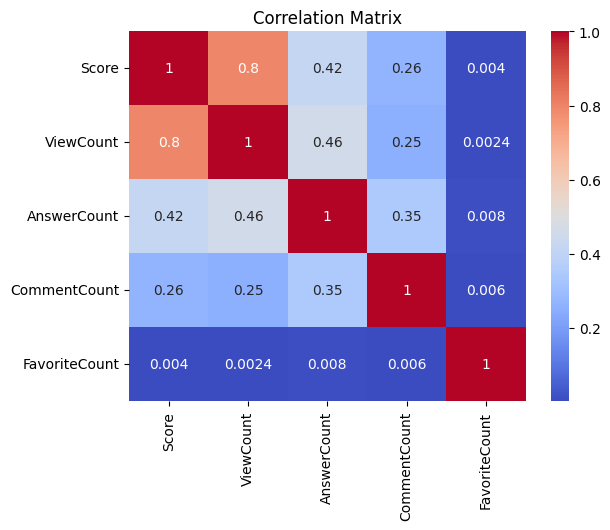

In [23]:
# Matrice de corrélation
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = df[['Score', 'ViewCount', 'AnswerCount', 'CommentCount', 'FavoriteCount']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


## Évolution du Nombre de Questions Dans le Temps

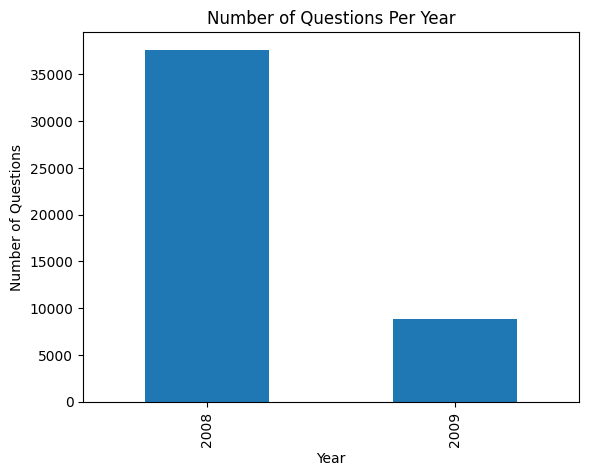

In [24]:
# Comptage des questions par année
df['CreationYear'] = pd.to_datetime(df['CreationDate']).dt.year
questions_per_year = df['CreationYear'].value_counts().sort_index()
questions_per_year.plot(kind='bar', title='Number of Questions Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Questions')
plt.show()

In [25]:
!pip install wordcloud matplotlib

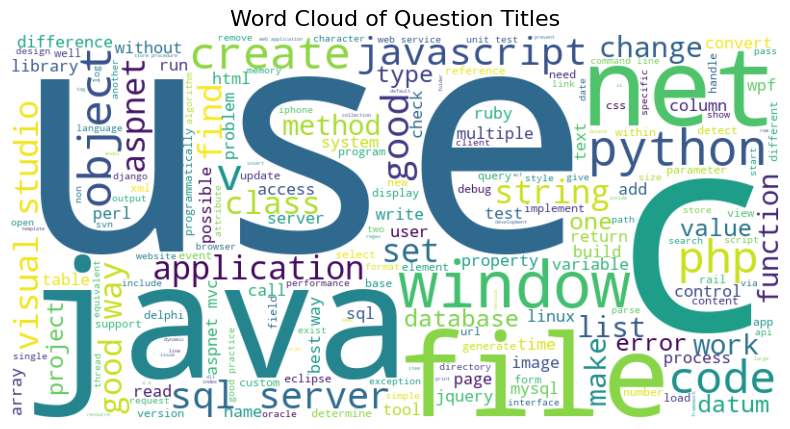

In [26]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combiner tous les titres des questions en un seul texte
text = " ".join(title for title in df['Title'] if isinstance(title, str))

# Générer le nuage de mots
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Question Titles", fontsize=16)
plt.show()


## Longueur moyenne des questions

In [27]:
def cal_len(data):
    return len(data)

df['body_length']= df['Body'].str.split().apply(lambda z:cal_len(z))
df.head()

,Id,CreationDate,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Title,Body,Tags,CreationYear,body_length
0,4,2008-07-31 21:42:52,795,72107,13,4,0.0,convert decimal double c,want assign decimal variable tran double varia...,"[c#, floating-point, type-conversion, double, ...",2008,18
1,6,2008-07-31 22:08:08,319,23741,7,0,0.0,width collapse percentage width child element ...,absolutely position contain several child one ...,"[html, css, internet-explorer-7, ]",2008,33
2,9,2008-07-31 23:40:59,2211,797370,74,10,0.0,calculate someone age base datetime type birthday,give represent person birthday calculate age year,"[c#, .net, datetime, ]",2008,7
3,11,2008-07-31 23:55:37,1645,198982,41,3,0.0,calculate relative time c,give specific value display relative time like,"[c#, datetime, time, datediff, relative-time-s...",2008,7
4,13,2008-08-01 00:42:38,704,285740,27,10,0.0,determine user timezone,standard way web server able determine user ti...,"[html, browser, timezone, user-agent, timezone...",2008,16


In [28]:
df[df['body_length']==df['body_length'].max()]['Body']

1959    long ago beginning coder try find good book tu...
Name: Body, dtype: object

In [29]:
df[df['body_length']==df['body_length'].min()]['Body']

8742     
11504    
14602    
14850    
18543    
27224    
27454    
30694    
31277    
33037    
38264    
38763    
38989    
39693    
45901    
Name: Body, dtype: object

In [30]:
df['body_length'].min()

0

In [31]:
df['body_length'].max()

763

## Distribution des longueurs des abstracts

In [32]:
#Create generic plotter with Seaborn
def plot_count(count_ones,count_zeros,title_1,title_2,subtitle):
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
    sns.distplot(count_zeros,ax=ax1,color='Blue')
    ax1.set_title(title_1)
    fig.suptitle(subtitle)
    plt.show()

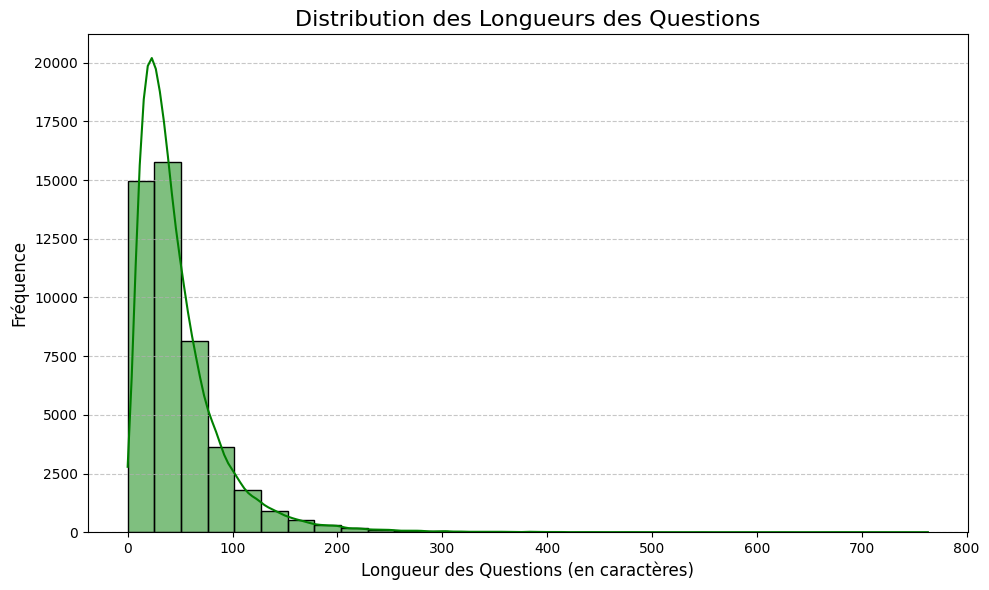

In [33]:
# Tracer l'histogramme
plt.figure(figsize=(10, 6))
sns.histplot(
    df['body_length'], 
    bins=30,  # Nombre de bins
    kde=True,  # Ajouter une courbe KDE pour visualiser la densité
    color='green'  # Couleur de l'histogramme
)
plt.title('Distribution des Longueurs des Questions', fontsize=16)
plt.xlabel('Longueur des Questions (en caractères)', fontsize=12)
plt.ylabel('Fréquence', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Ajouter une grille pour plus de lisibilité
plt.tight_layout()  # Ajuster les marges pour éviter que le graphique soit coupé
plt.show()

# Modèles LLM